# Hands-On Machine Learning

## Session 9: Generative Adversarial networks
by Justus Schock, Christoph Haarburger, Laxmi Gupta

### Goals of this Session

In this session you will...
* learn how to implement a vanilla "Goodfellow-like" generative adversarial network
* train a GAN
* learn how to implement a convolutional GAN

We'll be working with the MNIST dataset, which you already know from previous sessions.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

%matplotlib inline

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
np.random.seed(0)

## Hyperparameters

In [ ]:
latent_size = 100
hidden_size = 256
image_size = 784
num_epochs = 10

**Task:** Set up the necessary transforms that are applied to the input images. You've already done this in the previous sessions.

We'd like to transform our data to `Tensor`s and normalize it with 0.5 mean and 0.5 variance.

After defining the transforms, we can initialize the dataset.

In [ ]:
from torchvision import transforms
from torchvision.datasets import MNIST

dset_path = os.path.join(os.path.abspath(os.environ["HOME"]),
                         'datasets')
# We make sure that the dataset is actually available
try:
    torchvision.datasets.MNIST(root=dset_path,
                               download=False)
except RuntimeError:
    if not os.path.isdir(dset_path):
            os.makedirs(dset_path)
    torchvision.datasets.MNIST(root=dset_path,
                               download=True)


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.5)])
dataset = MNIST(root=dset_path, download=True, transform=transform)# your job, dataset is located at dset_path


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



Now we can set up the `DataLoader`:

In [ ]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last=True)

**Task:** Visualize some samples of a single batch using the `plot_batch()` helper function.

In [ ]:
from utils import plot_batch

## Build Discriminator

**Task:** Implement the Discriminator as a sequential model consisting of three `nn.Linear`, `nn.ReLU` layers and a binary output with `nn.Sigmoid` activation.

We will feed the images into the network as flattened arrays.

In [ ]:
dataset.data[0].shape

torch.Size([28, 28])

In [ ]:
discriminator = nn.Sequential(
    nn.Linear(in_features=image_size, out_features=hidden_size),
    nn.ReLU(),
    nn.Linear(in_features=hidden_size, out_features=hidden_size),
    nn.ReLU(),
    nn.Linear(in_features=hidden_size, out_features=1),
    nn.Sigmoid()
)


## Build Generator

**Task:** Implement the Generator as a sequential model of two `nn.Linear` layers with `nn.ReLU()` activation and a final `nn.Linear` layer with `nn.Tanh` activation that maps from a random vector to the original flattened image dimension.

In [ ]:
generator = nn.Sequential(
    nn.Linear(in_features=latent_size, out_features=256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)

### General Setup for Training

By the follwing line we can dynamically determine whether we want to run our model and optimization on CPU or GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Task:** Send both `generator` and `discriminator` to the `device`. You can do that simply by calling `{mymodule}.to(device)`

In [ ]:
generator.to(device)
discriminator.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

**Task:** Now we can initialize the optimizers for both generator and discriminator. We'll use `Adam` with a learning rate of `0.0005` here.

In [ ]:
g_optimizer = torch.optim.Adam(params=generator.parameters(), lr=0.0005)
d_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=0.0005)

Now we only need to initialize the cross entropy loss before getting started with the training loop 😊

Compute BCE_Loss using real images where `BCE_Loss` = - y * log(D(x)) - (1-y) * log(1 - D(x)). The second term of the loss is always zero since real_labels == 1.

In [ ]:
criterion = nn.BCELoss()

### Training Loop
Finally, we can write the training loop and look at actual results. Since this is quite a bit of code, please perform the implementation in the follwing steps:

**Task:** Train your GAN and watch your fake images get better and better. It might take up to 20 Minutes to produce good results.

Epoch [0/10], Step [200/468], d_loss: 0.3306, g_loss: 2.2088, D(x): 0.90, D(G(z)): 0.18
Epoch [0/10], Step [400/468], d_loss: 0.7838, g_loss: 4.3640, D(x): 0.79, D(G(z)): 0.18


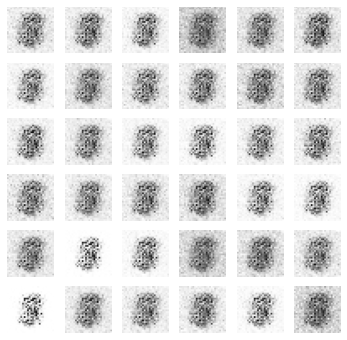

Epoch [1/10], Step [200/468], d_loss: 0.2707, g_loss: 5.1665, D(x): 0.96, D(G(z)): 0.16
Epoch [1/10], Step [400/468], d_loss: 0.3181, g_loss: 2.1995, D(x): 0.86, D(G(z)): 0.11


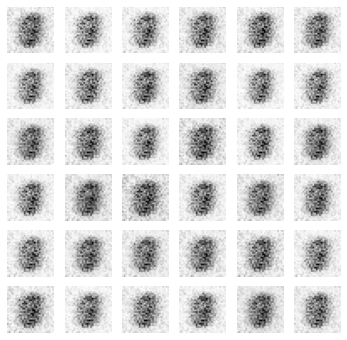

Epoch [2/10], Step [200/468], d_loss: 0.1540, g_loss: 5.0913, D(x): 0.96, D(G(z)): 0.07
Epoch [2/10], Step [400/468], d_loss: 0.2887, g_loss: 2.9285, D(x): 0.90, D(G(z)): 0.15


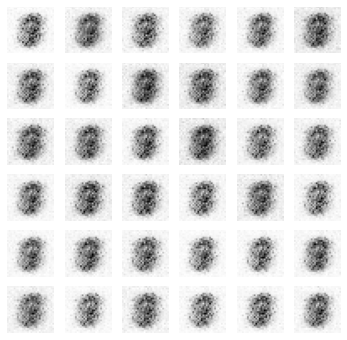

Epoch [3/10], Step [200/468], d_loss: 0.1852, g_loss: 3.7110, D(x): 0.94, D(G(z)): 0.11
Epoch [3/10], Step [400/468], d_loss: 1.1758, g_loss: 1.0426, D(x): 0.58, D(G(z)): 0.37


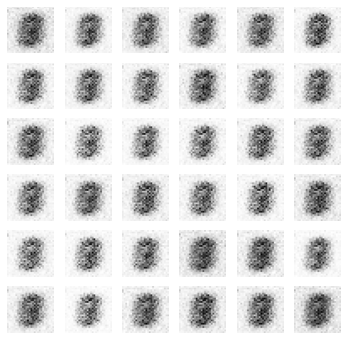

Epoch [4/10], Step [200/468], d_loss: 0.2733, g_loss: 4.1340, D(x): 0.91, D(G(z)): 0.09
Epoch [4/10], Step [400/468], d_loss: 0.2557, g_loss: 3.4859, D(x): 0.93, D(G(z)): 0.14


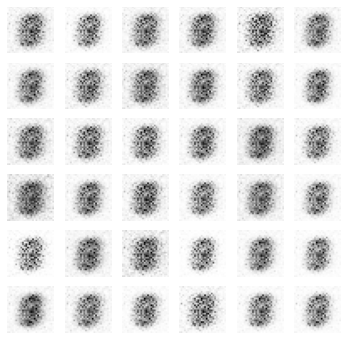

Epoch [5/10], Step [200/468], d_loss: 0.5185, g_loss: 3.0630, D(x): 0.84, D(G(z)): 0.20
Epoch [5/10], Step [400/468], d_loss: 1.0314, g_loss: 2.3247, D(x): 0.67, D(G(z)): 0.28


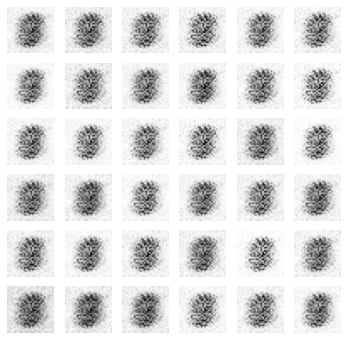

Epoch [6/10], Step [200/468], d_loss: 1.6536, g_loss: 0.7178, D(x): 0.48, D(G(z)): 0.36
Epoch [6/10], Step [400/468], d_loss: 0.5417, g_loss: 1.5776, D(x): 0.78, D(G(z)): 0.24


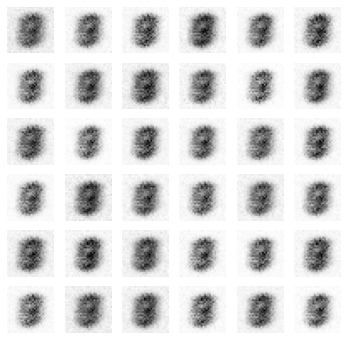

Epoch [7/10], Step [200/468], d_loss: 0.9550, g_loss: 1.3793, D(x): 0.80, D(G(z)): 0.47
Epoch [7/10], Step [400/468], d_loss: 0.8770, g_loss: 1.7585, D(x): 0.68, D(G(z)): 0.19


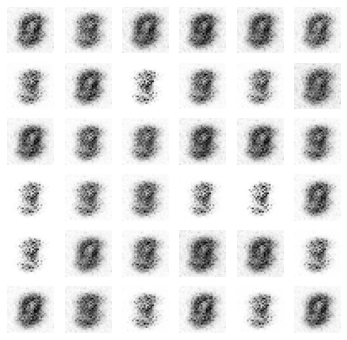

Epoch [8/10], Step [200/468], d_loss: 0.3973, g_loss: 2.6142, D(x): 0.88, D(G(z)): 0.19
Epoch [8/10], Step [400/468], d_loss: 0.0954, g_loss: 4.3116, D(x): 0.97, D(G(z)): 0.06


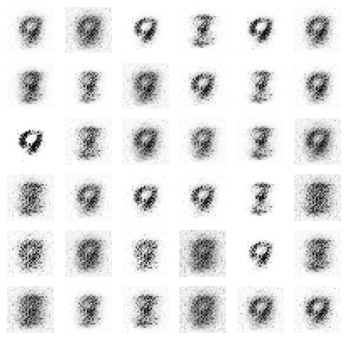

Epoch [9/10], Step [200/468], d_loss: 0.1871, g_loss: 4.6289, D(x): 0.93, D(G(z)): 0.07
Epoch [9/10], Step [400/468], d_loss: 2.5936, g_loss: 1.0763, D(x): 0.48, D(G(z)): 0.52


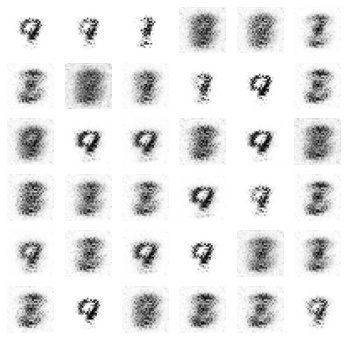

In [ ]:
total_step = len(data_loader)
for epoch in range(10):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape((images.size(0), -1)).to(device)
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                        real_score.mean().item(), fake_score.mean().item()))
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28).cpu().detach().numpy()
    plot_batch(fake_images)

Vanilla GANs as implemented above are difficult to train because of the high number of the many feedforward connections. DCGAN aims to overcome this by using Convolutional instead of Fully-connected layers.

In the next cells we will implement the same Training loop and setup as above, but using a DCGAN. 

## Build DCGAN

**Task:** Implement the generator of a DCGAN. To allow you to train the DCGAN also with a different dataset later, we change the input resolution from `28x28` as before to `64x64`.

### Generator

In [ ]:
g_c = torch.nn.Sequential(
    nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128 , 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
    nn.Tanh()
).to(device)

### Discriminator

**Task:** Implement the discriminator of a DCGAN. To allow you to train the DCGAN also with a different dataset later, we change the input resolution from `28x28` as before to `64x64`.

In [ ]:
d_c = torch.nn.Sequential(
    nn.Conv2d(1, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, 4, 1, 0, bias=False),

    nn.Sigmoid()
).to(device)


**Task:** Once again, we have to send the networks to our device and initialize the optimizers. Use the same learning rate as above.

In [ ]:
criterion = nn.BCELoss()

# send to device : up there

# optimizer

d_optimizer = torch.optim.Adam(params=d_c.parameters(), lr=0.0005)
g_optimizer = torch.optim.Adam(params=g_c.parameters(), lr=0.0005)

### Transforms

**Task:** To adapt the MNIST images to the new expected input dimension of `64x64`, we need to adapt our `transforms` accordingly. Find the right transform to resize all images to `64x64` and initialize dataset and data loader with the new transforms. 

In [ ]:
transform_c = transforms.Compose([
               transforms.Resize((64, 64)),          
               transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.5),
])
dataset = torchvision.datasets.MNIST(root=dset_path,
                                     train=True,
                                     transform=transform_c,
                                     download=False)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last=True)
print(dataset.data[1].shape)

torch.Size([28, 28])


### Training Loop Reloaded

Now we can build the training loop for the DCGAN. But don't worry, we can mostly copy our code from above. Take care of the changed tensor dimensions, though.

**Task:** Implement the Training loop from above and visualize a batch of fake data after every epoch. How does the training differ from the vanilla GAN training?

Epoch [0/10], Step [200/468], d_loss: 1.7269, g_loss: 24.9428, D(x): 1.00, D(G(z)): 0.81
Epoch [0/10], Step [400/468], d_loss: 0.0046, g_loss: 8.1734, D(x): 1.00, D(G(z)): 0.00


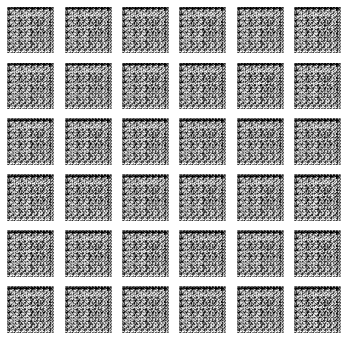

Epoch [1/10], Step [200/468], d_loss: 0.0651, g_loss: 8.9245, D(x): 0.98, D(G(z)): 0.02
Epoch [1/10], Step [400/468], d_loss: 0.0049, g_loss: 7.4680, D(x): 1.00, D(G(z)): 0.00


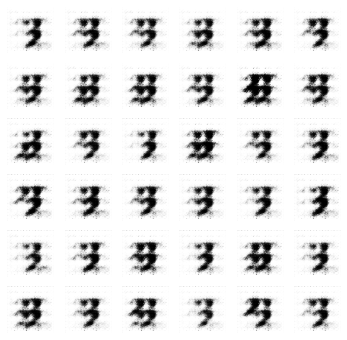

Epoch [2/10], Step [200/468], d_loss: 0.0193, g_loss: 7.5675, D(x): 0.99, D(G(z)): 0.01
Epoch [2/10], Step [400/468], d_loss: 0.1021, g_loss: 7.4969, D(x): 0.93, D(G(z)): 0.01


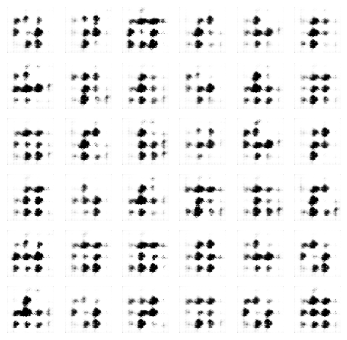

Epoch [3/10], Step [200/468], d_loss: 0.0399, g_loss: 6.2227, D(x): 0.99, D(G(z)): 0.02
Epoch [3/10], Step [400/468], d_loss: 0.0992, g_loss: 5.4011, D(x): 0.96, D(G(z)): 0.04


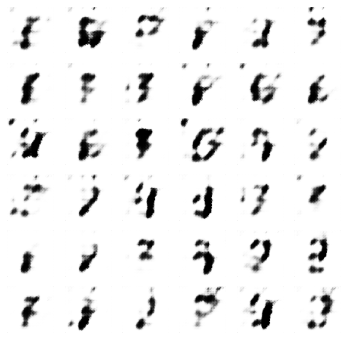

Epoch [4/10], Step [200/468], d_loss: 0.0418, g_loss: 5.0510, D(x): 0.99, D(G(z)): 0.02
Epoch [4/10], Step [400/468], d_loss: 0.7192, g_loss: 11.5738, D(x): 0.65, D(G(z)): 0.00


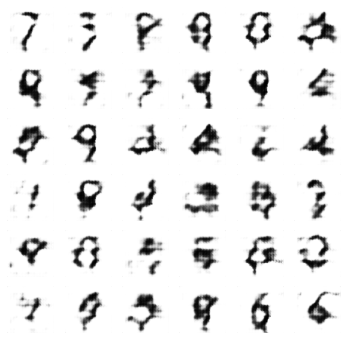

Epoch [5/10], Step [200/468], d_loss: 0.0759, g_loss: 6.0479, D(x): 0.97, D(G(z)): 0.03
Epoch [5/10], Step [400/468], d_loss: 0.1693, g_loss: 7.8110, D(x): 0.89, D(G(z)): 0.02


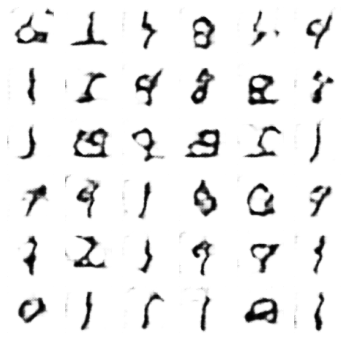

Epoch [6/10], Step [200/468], d_loss: 0.1068, g_loss: 2.5668, D(x): 0.99, D(G(z)): 0.08
Epoch [6/10], Step [400/468], d_loss: 0.1017, g_loss: 5.1102, D(x): 0.92, D(G(z)): 0.01


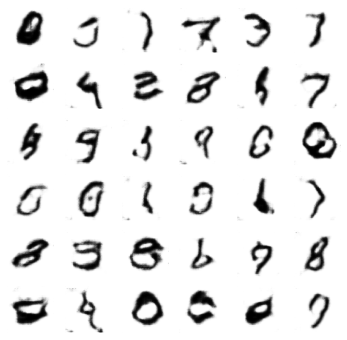

In [ ]:
total_step = len(data_loader)
for epoch in range(100):
    for i, (images, _) in enumerate(data_loader):
        images=images.to(device)
        # Create the labels which are later used as input for the BCE loss
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        outputs = d_c(images)
        d_loss_real = criterion(outputs.reshape(128,1), real_labels.reshape(128,1))
        real_score = outputs
        # Compute BCELoss using fake images
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        fake_images = g_c(z)
        outputs = d_c(fake_images)
        d_loss_fake = criterion(outputs.reshape(128,1), fake_labels.reshape(128,1))
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        fake_images = g_c(z)
        outputs = d_c(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        g_loss = criterion(outputs.reshape(128,1), real_labels.reshape(128,1))
        
        # Backprop and optimize
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                        real_score.mean().item(), fake_score.mean().item()))
    fake_images = fake_images.reshape(fake_images.size(0), 1, 64, 64).cpu().detach().numpy()
    plot_batch(fake_images)


the error is because the training has been stopped.

## Discussion
What potential problems do you see with GAN training? How and why does DCGAN improve over vanilla GAN?

## Bonus Task

Congratulations, you've successfully trained a DCGAN that can generate MNIST numbers. If you are brave, it's time to generate some more complex images.

**Task:** Have a look at the datasets that are included in `torchvision` and train a DCGAN with another dataset.

### Feedback

That's it, we're done 👏🏼🍻

If you have any suggestions on how we could improve this session, please let us know in the following cell. What did you particularly like or dislike? Did you miss any contents?